## PropDRM - deep learning from propositionalized data structures

This notebook serves as an illustratory example of the PropDRM approach, proposed by Lavrač et al. (MLJ, 2020).
The key idea of PropDRM builds on the concept of Wordification (Chapter 3), coupled with modern deep neural networks. The implementation in this notebook follows the key ideas in the paper, however, for the C++ version of the code (the original), please consult: https://github.com/SkBlaz/PropStar

- python-rdm==0.3.5
- tabulate==0.8.7
- tensorflow >= 2.0
- shap>=0.37
- seaborn>=0.38
- matplotlib>=3.0.0

We begin by refreshing the notion of Wordification:

In [3]:
import csv
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML, display
import tabulate
with open('data/molecule.csv') as csvfile:
    rows = [row for row in csv.reader(csvfile)]
print('table "molecule"')
display(HTML(tabulate.tabulate(rows[:5], tablefmt='html', showindex=True)))

table "molecule"


0,molecule_id,ind1,inda,logp,lumo,mutagenic
1,varchar,integer,integer,float,float,varchar
2,primary key,,,,,
3,d1,1,0,4.23,-1.246,yes
4,d10,1,0,4.62,-1.387,yes


The Wordification is performed as done in Chapter 3.

In [9]:
from rdm.db import DBContext, CSVConnection
from rdm.db import OrangeConverter
from rdm.wrappers import Wordification

# Establish a connection
connection = CSVConnection(['data/molecule.csv','data/atom.csv','data/bond.csv'])
context = DBContext(connection, target_table='molecule', target_att='mutagenic')

# Convert relational context
conv = OrangeConverter(context)

In [12]:
from pprint import pprint

# We'll use TF-IDF scoring
wordificator = Wordification(conv.target_Orange_table(), conv.other_Orange_tables(), context, word_att_length=2)
wordificator.run()
wordificator.calculate_weights(measure='tfidf')
molecules_tfidf = wordificator.to_orange()
feature_names = trains_tfidf.domain.attributes

In [13]:
import numpy as np
# Prepare for learning

X = molecules_tfidf.X
Y = molecules_tfidf.Y
y_names = np.array([x.name for x in trains_tfidf.domain.attributes])

# Let's do a 80:20 split
first_fifth = int(X.shape[0]/5)

# partition the data sets
X_test = X[0:first_fifth]
X_train = X[first_fifth:]
Y_test = Y[0:first_fifth]
Y_train = Y[first_fifth:]

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# A simple neural network with one hidden layer
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=4, verbose=0)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 8)                 21232     
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 21,241
Trainable params: 21,241
Non-trainable params: 0
_________________________________________________________________


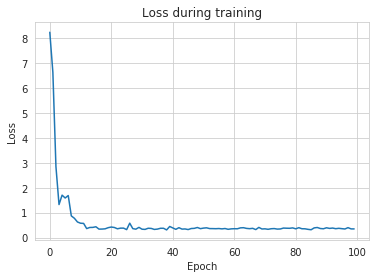

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

def visualize_training_curve(history_object):

    sns.lineplot(list(range(len(history_object.history['loss']))),history_object.history['loss'])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss during training")
    plt.show()
    
visualize_training_curve(history)

In [24]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
predictions = [np.round(x) for x in predictions]
crep = classification_report(predictions, Y_test, output_dict = True)['accuracy']
print(f"Achieved Accuracy of {crep}")

Achieved Accuracy of 0.7297297297297297


PropDRM can also be explained by using SHAP tool. For this example, we will use the Trains data set from Chapter 3!

In [40]:
import requests
## Download the trains data set
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/trains/trains.csv')
with open("data/trains.csv", "wb") as file:
    file.write(request.content)
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/trains/cars.csv')
with open("data/cars.csv", "wb") as file:
    file.write(request.content)

# Establish a connection
connection = CSVConnection(['data/trains.csv','data/cars.csv'])
context = DBContext(connection, target_table='trains', target_att='direction')

# Convert relational context
conv = OrangeConverter(context)

# We'll use TF-IDF scoring
wordificator = Wordification(conv.target_Orange_table(), conv.other_Orange_tables(), context, word_att_length=2)
wordificator.run()
wordificator.calculate_weights()
trains_tfidf = wordificator.to_orange()
feature_names = trains_tfidf.domain.attributes


X = trains_tfidf.X
Y = trains_tfidf.Y
y_names = np.array([x.name for x in trains_tfidf.domain.attributes])

# Let's do a 80:20 split
first_fifth = int(X.shape[0]/5)

# partition the data sets
X_test = X[0:first_fifth]
X_train = X[first_fifth:]
Y_test = Y[0:first_fifth]
Y_train = Y[first_fifth:]

Next, we define a neural network architecture, as done before.

In [41]:
class NeuralNet:
    """
    A neural network class. This class serves during SHAP-based explanations for its predict_proba capability.
    """
    
    def __init__(self):
        
        ## Initialization of a generic neural network model
        self.model = keras.Sequential()
        self.model.add(keras.Input(shape=(X_train.shape[1],)))
        self.model.add(layers.Dense(8, activation="relu"))
        self.model.add(layers.Dropout(0.2))
        self.model.add(layers.Dense(1, activation="sigmoid"))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    def fit(self, Xdata, Ydata):
        
        ## A sklearn-like fit function
        history = self.model.fit(Xdata, Ydata, epochs=100, batch_size=2, verbose=0)
        return history
        
    def predict_proba(self, Xdata):
        
        ## A sklearn-like predict_proba function
        return self.model.predict(Xdata)
        

The neural network is trained on the training data next.

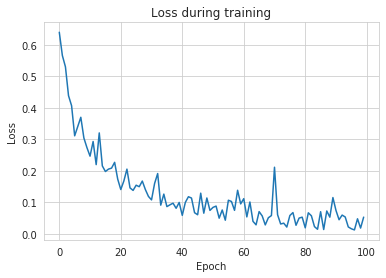

In [42]:
import shap
import pandas as pd
shap.initjs()

## Initialize the neural network
neuralNetwork = NeuralNet()

## Get the history object
history = neuralNetwork.fit(X_train, Y_train)

## Visualize the training curve
visualize_training_curve(history)

The SHAP tool expores how combinations of features effectively impact model output. The final results are the features that impacted the output the most.

In [43]:
# use Kernel SHAP to explain test set predictions
X_train = pd.DataFrame(X_train)
X_train.columns = feature_names
X_test = pd.DataFrame(X_test)
X_test.columns = feature_names
explainer = shap.KernelExplainer(neuralNetwork.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

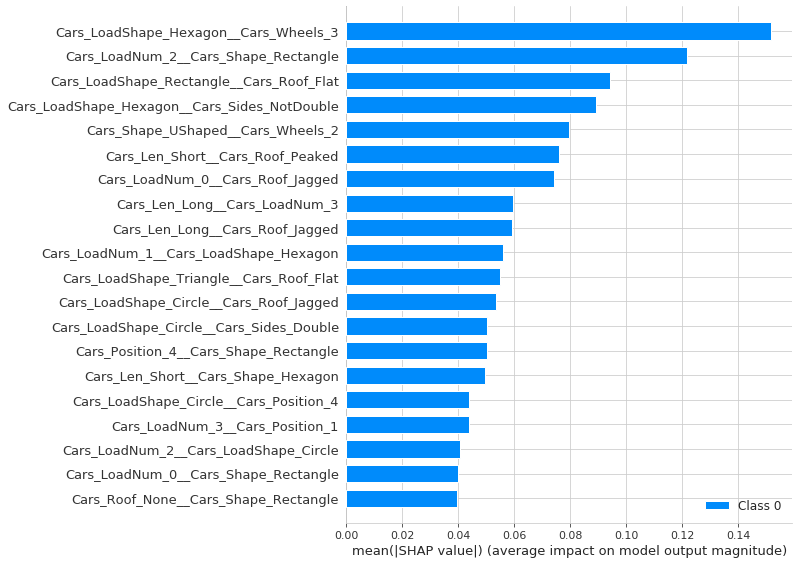

In [44]:
shap.summary_plot(shap_values, X_test) ## Plot the relevances of features on the model output!

The SHAP's plot offers direct insight into which features were the most relevant for the neural classifier. The first one, *Cars_LoadShape_Diamond_Cars_Position_2* indicates that the cart's shape and position are amongst the most relevant attributes.